(10475, 3)
[[512.11133599 283.71243938   1.        ]
 [513.05751585 283.88548715   1.        ]
 [513.20805091 283.57279347   1.        ]
 ...
 [491.09927035 276.82551667   1.        ]
 [491.54816054 276.66461703   1.        ]
 [492.01578085 276.48274925   1.        ]]


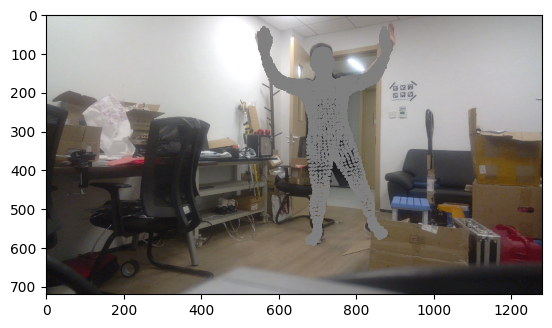

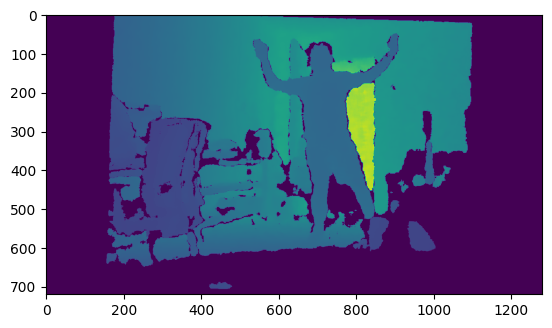

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from demo import open_image
import open3d as o3d
from PIL import Image, ImageOps

# Load the mesh and camera parameters
index = 125
mesh_output_path = 'demo_out/frame'+str(index)+'_multiHMR_896_L.png.npy'

def match_mesh_to_figure(mesh_path, img_size):
    info = np.load(mesh_output_path, allow_pickle=True).item()
    camera_param = info['camera'][0] # intrinsic camera parameters
    mesh = info['l_mesh'][0] # only one person
    
    # plt.figure(figsize=(5, 5))
    # plt.scatter(mesh[:, 0], -mesh[:, 1], s=1, c='gray')
    # plt.xlim(-0.4, 0.8)
    # plt.ylim(-0.8, 1.0)

    fx = camera_param[0, 0]
    fy = camera_param[1, 1]
    cx = camera_param[0, 2]
    cy = camera_param[1, 2]
    project_matrix  = [[fx, 0, cx],[0, fy, cy],[0, 0, 1]]
    project_matrix = np.array(project_matrix)

    points_2d = mesh @ project_matrix.T
    points_2d = points_2d / points_2d[:, 2][:, np.newaxis]
    return points_2d, mesh


def mesh_to_pixel(mesh):
    mesh = np.round(mesh).astype(int)
    return np.unique(mesh, axis=0)

def hidden_point_removal(mesh):
    '''
    No use in current version
    '''
    pcd = o3d.geometry.PointCloud()
    diameter = 100.0
    camera = [0, 0, diameter]
    radius = diameter * 100 # todo 

    pcd.points = o3d.utility.Vector3dVector(mesh)
    _, pt_map = pcd.hidden_point_removal(camera, radius)

    pcd = pcd.select_by_index(pt_map)
    points_from_camera_view = np.asarray(pcd.points)
    return points_from_camera_view

def resize_point_cloud(mesh, img_size, padding_num, target_height, original_img_size):
    original_width, original_height = original_img_size
    x, y, z = mesh[:, 0], mesh[:, 1], mesh[:, 2]
    x = x * original_width / img_size
    y = (y - padding_num) * original_height / target_height
    z = z
    new_mesh = np.stack((x, y, z), axis=-1)
    return new_mesh

def get_image(path):
    return np.fromfile(path, dtype=np.uint16).reshape(720, 1280)

def image_name(root, index):
    depth_file = None
    color_file = None

    for file in os.listdir(os.path.join(root, 'depth_images')):
        if f'_{index}.raw' in file:
            depth_file = file
            break
    for file in os.listdir(os.path.join(root, 'renamed_images')):
        if str(index).zfill(3) in file:
            color_file = file
            break
    if depth_file is None or color_file is None:
        print("No matched file found.")
        return None
    return os.path.join(root,'depth_images',depth_file), os.path.join(root,'renamed_images',color_file)

def get_real_world_coordination(mesh, camera_param, depth_img):
    (fx, fy, cx, cy) = camera_param 

    z = depth_img[mesh[:, 1], mesh[:, 0]]
    x = (mesh[:, 0] - cx) * z / fx
    y = (mesh[:, 1] - cy) * z / fy

    new_mesh = np.stack((x, y, z), axis=-1)
    return new_mesh
    
    

img_size = 896
mesh, mesh_real_world_distance = match_mesh_to_figure(mesh_output_path, img_size)
x, compressed_fig = open_image("example_data/frame"+str(index)+".png", img_size)

print(mesh.shape)
print(mesh)

mesh = mesh_to_pixel(mesh)

original_img = cv2.imread("example_data/frame"+str(index)+".png")
original_width = original_img.shape[1]
original_height = original_img.shape[0]
target_height = original_height * img_size / original_width
padding_num = int((img_size - target_height) / 2)
mesh = resize_point_cloud(mesh, img_size, padding_num, target_height, (original_width, original_height))
mesh = mesh_to_pixel(mesh)

plt.figure()
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR))
plt.scatter(mesh[:, 0], mesh[:, 1], s=1, c='gray')


root = '/root/image2human'
depth_file, color_file = image_name(root, index)
depth_image = get_image(depth_file)
color_image = np.array(Image.open(color_file))

plt.figure()
plt.imshow(depth_image)

# real_world_camera_param = [836.215820, 836.215759, 637.781738, 364.227631]
# new_mesh = get_real_world_coordination(mesh, real_world_camera_param, depth_image)/1000
# print('final mesh shape', mesh.shape)
# fig = plt.figure(figsize=[5,5])
# plt.scatter(mesh[:, 0], -mesh[:, 1], s=1, c='gray')
# plt.xlim(-0.4, 0.8)
# plt.ylim(-0.8, 1.0)
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(mesh[:, 0], mesh[:, 1], mesh[:, 2], c='gray')
# ax.view_init(elev=-90, azim=-90)
# print(np.mean(mesh[:,2]))

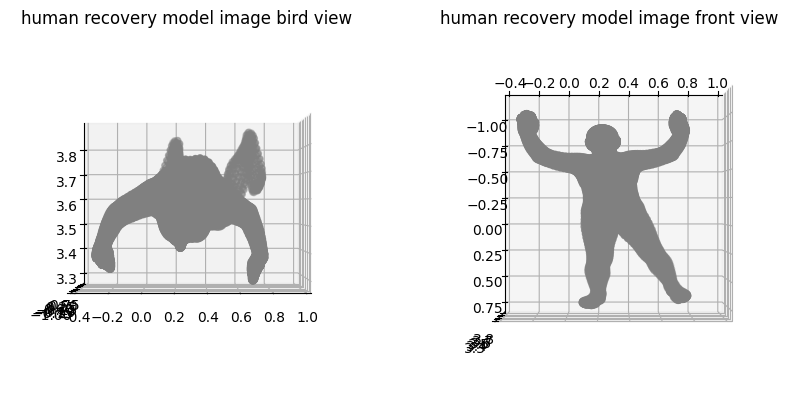

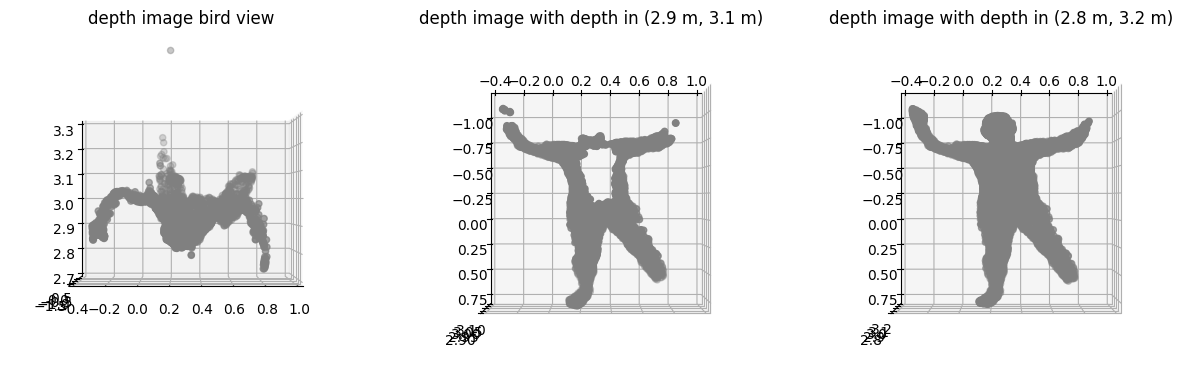

(720, 1280)


In [64]:
fig = plt.figure(figsize=[10,5])
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(mesh_real_world_distance[:, 0], mesh_real_world_distance[:, 1], mesh_real_world_distance[:, 2], c='gray')
ax1.view_init(elev=0, azim=-90)
ax1.set_xlim(-0.4, 1)
ax1.title.set_text('human recovery model image bird view')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(mesh_real_world_distance[:, 0], mesh_real_world_distance[:, 1], mesh_real_world_distance[:, 2], c='gray')
ax2.view_init(elev=-90, azim=-90)
ax2.title.set_text('human recovery model image front view')
ax2.set_xlim(-0.4, 1)
ax2.set_ylim(-1.2, 0.8)

plt.show()

real_world_camera_param = [836.215820, 836.215759, 637.781738, 364.227631]

depth_mesh = get_real_world_coordination(mesh, real_world_camera_param, depth_image)/1000

human_mesh = depth_mesh[(depth_mesh[:,2]>2.9) & (depth_mesh[:,2]<3.1)]
human_mesh_2 = depth_mesh[(depth_mesh[:,2]>2.8) & (depth_mesh[:,2]<3.2)]

fig = plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(depth_mesh[:, 0], depth_mesh[:, 1], depth_mesh[:,2], c='gray')
ax1.view_init(elev=0, azim=-90)
ax1.set_zlim(2.7,3.3)
ax1.set_xlim(-0.4, 1)
ax1.title.set_text('depth image bird view')


ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(human_mesh[:, 0], human_mesh[:, 1], human_mesh[:,2], c='gray')
ax2.view_init(elev=-90, azim=-90)
ax2.title.set_text('depth image with depth in (2.9 m, 3.1 m)')
ax2.set_xlim(-0.4, 1)
ax2.set_ylim(-1.2, 0.8)

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(human_mesh_2[:, 0], human_mesh_2[:, 1], human_mesh_2[:,2], c='gray')
ax3.view_init(elev=-90, azim=-90)
ax3.title.set_text('depth image with depth in (2.8 m, 3.2 m)')
ax3.set_xlim(-0.4, 1)
ax3.set_ylim(-1.2, 0.8)


plt.show()

print(depth_image.shape)

In [2]:
fx = real_world_camera_param[0]
fy = real_world_camera_param[1]

hfov = np.rad2deg(2 * np.arctan(original_width / (2 * fx)))
vfov = np.rad2deg(2 * np.arctan(original_height / (2 * fy)))

print('hfov', hfov)
print('vfov', vfov)

print('vitual camera focal', fx * img_size / original_width)

print(hfov/vfov)
print(original_width/original_height)


hfov 74.85746553359118
vfov 46.58480966076631
vitual camera hfov 52.40022587351383
1.6069071888177333
1.7777777777777777
